In [1]:
from importlib import reload
from astropy import units as u
from astropy import constants as const
# from astropy.modeling.models import BlackBody
# from astropy.units.equivalencies import spectral

import math

import numpy as np
import matplotlib.pyplot as plt
import pandas
from scipy.interpolate import UnivariateSpline

# from scipy.special import expn
# from scipy.integrate import simpson

from src import astro530
from src import N_integrator

## Partition Function

In [2]:
ion_df = pandas.read_csv("data/ioniz.csv").fillna("-")
ion_df

,Z,Element,MMW,1ion,2ion,3ion
0,1,H,1.008,13.6,-,-
1,2,He,4.003,24.59,54.42,-
2,3,Li,6.941,5.39,75.64,122.45
3,4,Be,9.012,9.32,18.21,153.89
4,5,B,10.811,8.3,25.15,37.93
...,...,...,...,...,...,...
87,88,Ra,226.025,5.28,10.14,34
88,89,Ac,227.000,6.9,12.1,20
89,90,Th,232.038,6,11.5,20
90,91,Pa,230.040,-,-,-


In [3]:
rpf_df = pandas.read_csv("data/RepairedPartitionFunctions.csv")#.fillna("-")
rpf_df#.loc[rpf_df["Theta="] == "Sc++"]

,Theta=,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,log_g0
0,H,0.368,0.303,0.301,0.301,0.301,0.301,0.301,0.301,0.301,0.301,0.301
1,He,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
2,He+,0.301,0.301,0.301,0.301,0.301,0.301,0.301,0.301,0.301,0.301,0.301
3,Li,-,0.987,0.488,0.359,0.320,0.308,0.304,0.302,0.302,0.302,0.301
4,Be,-,0.328,0.087,0.025,0.007,0.002,0.001,0.000,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
242,Pa+,2.985,2.413,2.169,1.990,1.846,1.723,1.615,1.515,1.419,1.323,1.519
243,Pa++,-,2.106,1.845,1.652,1.469,1.281,1.088,0.895,0.708,0.532,-
244,U,3.221,2.696,2.298,2.032,1.849,1.719,1.623,1.552,1.498,1.455,1.929
245,U+,2.694,2.031,1.719,1.553,1.455,1.392,1.349,1.317,1.292,1.270,1.716


In [4]:
nion_df = pandas.read_csv("data/nist_ioniz.csv").fillna(0)
nion_df

,Z,Element,mu,1ion
0,1,H,1.008,13.598434
1,2,He,4.003,24.587388
2,2,He+,4.003,54.417763
3,3,Li,6.941,5.391715
4,3,Li+,6.941,75.640094
...,...,...,...,...
268,91,Pa+,230.04,11.900000
269,91,Pa++,230.04,19.000000
270,92,U,227,6.194050
271,92,U+,227,11.590000


In [5]:
b = "ScII"
a = list(b)
"".join(a[:-2])+"+"

'Sc+'

In [6]:
def species_name_correction(species):
    species_list = list(species)
    if len(species_list) > 3:
        if species_list[-1] == "I" and species_list[-2] == "I" and species_list[-3] == "I":
            species = "".join(species[:-3]+"++")
        elif species_list[-1] == "I" and species_list[-2] == "I":
            species = "".join(species[:-2]+"+")
        elif species_list[-1] == "I":
            species = "".join(species[:-1])
            
    elif len(species_list) > 2:
        if species_list[-1] == "I" and species_list[-2] == "I":
            species = "".join(species[:-2]+"+")
        elif species_list[-1] == "I":
            species = "".join(species[:-1])
            
    elif len(species_list) > 1:
        if species_list[-1] == "I":
            species = "".join(species[:-1])
            
    return species
def partition(species="H",temp=5000,s_val = 0,k_val = 2,func = None, **kwargs):
    """Partition function from Gray 3 ed.
    
    Inputs:
    
    species (string): Species name you want a partition function for. Can be 
                    inputted as XIII or X++. If species is not in Gray, function 
                    will tell you.
                    
    temp (float or array): Temperature of material to look at in Kelvin.
    
    s_val: for spline value
    
    k_val: for spline curve
    
    Outputs:
    
    Partition function value of a species given a temperature"""
    
    try:
        rpf_df = pandas.read_csv("data/RepairedPartitionFunctions.csv")
    except:
        pf_df = pandas.read_csv("../data/RepairedPartitionFunctions.csv")
    
#     species_list = list(species)
#     if len(species_list) > 3:
#         if species_list[-1] == "I" and species_list[-2] == "I" and species_list[-3] == "I":
#             species = "".join(species[:-3]+"++")
#         elif species_list[-1] == "I" and species_list[-2] == "I":
#             species = "".join(species[:-2]+"+")
#         elif species_list[-1] == "I":
#             species = "".join(species[:-1])
            
#     elif len(species_list) > 2:
#         if species_list[-1] == "I" and species_list[-2] == "I":
#             species = "".join(species[:-2]+"+")
#         elif species_list[-1] == "I":
#             species = "".join(species[:-1])
            
#     elif len(species_list) > 1:
#         if species_list[-1] == "I":
#             species = "".join(species[:-1])

    species = species_name_correction(species)
    
    if species == "H+": 
        species = "He"
        
    elif species == "H-": 
        chi = 0.755
        g0 = 1
        theta = 5040/temp
        
        return g0*10**(-theta*chi)
    try:
        data = rpf_df.loc[rpf_df["Theta="]==species].to_numpy()[0][1:-1]
    except:
        species = "He"
        data = rpf_df.loc[rpf_df["Theta="]==species].to_numpy()[0][1:-1]
    
    log_g0 = float(rpf_df.loc[rpf_df["Theta="]==species].log_g0.values[0])
    
    th = 5040/temp
    
    theta = []
    temp_data = []
    
    for i,d in enumerate(data):
        if d != "-":
            temp_data.append(float(d))
            theta.append(0.2*(i+1))
            
    if log_g0 != "-":
        temp_data.append(log_g0)
        theta.append(10)
        temp_data.append(log_g0)
        theta.append(12)
        temp_data.append(log_g0)
        theta.append(15)
        temp_data.append(log_g0)
        theta.append(20)
        
    data = np.array(temp_data,dtype="float")
    theta = np.array(theta)
    
    if func == None:
        p_US = UnivariateSpline(theta,data,s=0,k=k_val)
        if k_val != 1:
            temp = np.linspace(0.2,20,50)
            p_US = UnivariateSpline(temp, p_US(temp),s=0,k=1)
        
        output_arr = p_US(th)
        if type(th) != float:
            for i,theta in enumerate(th):
                if theta > 20:
                    output_arr[i] = log_g0
        else:
            if th > 20:
                output_arr = log_g0
        return 10**output_arr
    else: 
        print("Function is not ready for this choice") 
        return 0
    

In [47]:
def saha_LTE(species = "H", temp = 5000,Pe = None):
    ion_df = pandas.read_csv("data/ioniz.csv").fillna("-")
    nion_df = pandas.read_csv("data/nist_ioniz.csv").fillna(0)
    
    species = species_name_correction(species)
    
    output = 0.665*temp**(5/2)
    
    if Pe != None:
        try:
            output /= Pe
        except:
            pass
    s_list = list(species)
    
    r = 0
    
    for c in s_list:
        if c == "+":
            r+=1
    Ur = partition(species=species,temp=temp)
    
    if species != "H-":
        Ur1 = partition(species=species+"+",temp=temp)

        print(nion_df.loc[nion_df["Element"]==species])
        try:
            chi = (nion_df.loc[nion_df["Element"]==species]["1ion"]).values[0]
        except:
            raise ValueError("Try another species, this one cannot be found.")
            
    else:
        Ur1 = partition(species="H",temp=temp)
        chi = 0.755
        #print(Ur)
    return 10**(np.log10(output) + np.log10(Ur1/Ur)+(-5040/temp*chi))
    

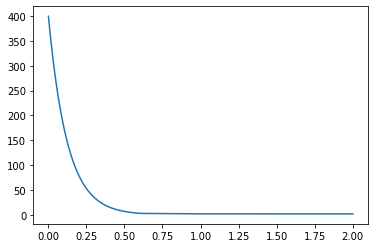

In [8]:
theta_arr = np.linspace(1e-3,2,300)
p_arr = partition(species="Li",temp = 5040/theta_arr)
#plt.xscale("log")
plt.plot(theta_arr,p_arr)

In [9]:
myplot_specs = {
    'font.size' : 20
}

plt.rcParams.update(myplot_specs)

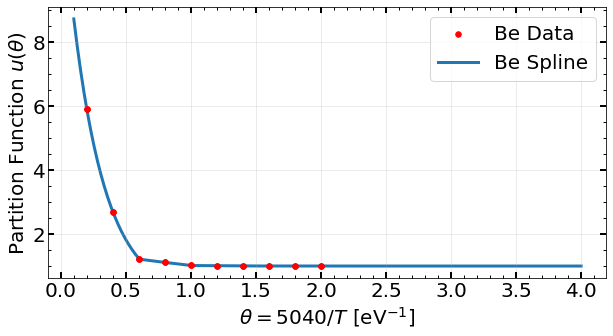

In [50]:
species = "Be"
fig, ax = plt.subplots(figsize = (10,5),nrows=1, ncols=1)
    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

theta_arr = np.linspace(0.1,4,300)
p_arr = partition(species=species,temp = 5040/theta_arr)

theta_og = np.linspace(0.2,2,10)
p_og = partition(species=species,temp = 5040/theta_og)

output_file = "plots/11.pdf"

ax.scatter(theta_og,p_og,label=str(species)+" Data",marker="o",s=30,c="r",zorder = 2)
ax.plot(theta_arr,p_arr, label=species+" Spline",lw=3,zorder= 0)
ax.scatter(theta_og,p_og,marker="o",s=30,c="r")

#ax.plot(nu,y_arr*1e5, label="Total Emergent Flux",lw=3)
#ax.plot(nu,EB_approx, label="EB Approx.",lw=3)

ax.set_xlabel(r"$\theta = 5040/T~$[eV$^{-1}$]")
ax.set_ylabel(r"Partition Function $u(\theta)$")
#ax.set_xscale("log")
#ax.set_title(title)

ax.legend()

fig.savefig(output_file,bbox_inches='tight')

In [32]:
partition(species="Sc+",temp = 6000)

25.741626710887278

temp_arr  = np.linspace(.1,5,200)
p_arr = partition(species="U",temp = 5040/temp_arr)
theta_arr = np.linspace(0.2,2,10)

plt.plot(temp_arr,p_arr)
plt.scatter(theta_arr,(partition(species="U",temp = 5040/theta_arr)))

   Z Element     mu       1ion
0  1       H  1.008  13.598434


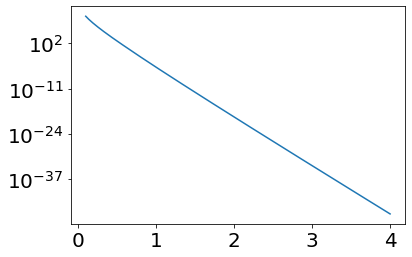

In [33]:
s = saha_LTE(species = "H", temp = 5040/theta_arr)
plt.yscale("log")
plt.plot(theta_arr,s)

In [37]:
saha_LTE(species="Sc+",temp=6000)

     Z Element     mu      1ion
58  21     Sc+  44.96  12.79977


0.012404043048757559

   Z Element     mu      1ion
6  4      Be  9.012  9.322699
   Z Element     mu      1ion
6  4      Be  9.012  9.322699


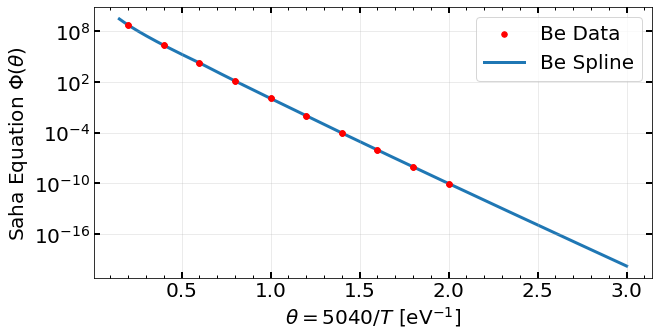

In [51]:
species = "Be"
fig, ax = plt.subplots(figsize = (10,5),nrows=1, ncols=1)
    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

theta_arr = np.linspace(0.15,3,300)
s_arr = saha_LTE(species=species,temp = 5040/theta_arr)

theta_og = np.linspace(0.2,2,10)
s_og = saha_LTE(species=species,temp = 5040/theta_og)

output_file = "plots/13.pdf"

ax.scatter(theta_og,s_og,label=str(species)+" Data",marker="o",s=30,c="r",zorder = 2)
ax.plot(theta_arr,s_arr, label=species+" Spline",lw=3,zorder= 0)
ax.scatter(theta_og,s_og,marker="o",s=30,c="r")

#ax.plot(nu,y_arr*1e5, label="Total Emergent Flux",lw=3)
#ax.plot(nu,EB_approx, label="EB Approx.",lw=3)

ax.set_xlabel(r"$\theta = 5040/T~$[eV$^{-1}$]")
ax.set_ylabel(r"Saha Equation $\Phi(\theta)$")
ax.set_yscale("log")
#ax.set_title(title)

ax.legend()

fig.savefig(output_file,bbox_inches='tight')